## **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install transformers

In [ ]:
import torch
from transformers import AutoTokenizer,RobertaTokenizerFast

## **Loading Fine-tuned Model**

In [ ]:
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('deepset/roberta-base-squad2')

# Load the fine-tuned modeol
model = torch.load("/content/drive/MyDrive/RoBerta/finetunedmodel",map_location=torch.device('cpu'))
model.eval()

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

## **Predictions on the Fine-tuned Model**

In [ ]:
def predict(context,query):

  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])  
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re

  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):

  prediction = predict(context,query)
  em_score = compute_exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score}")
  print("\n")

## **Model Testing**

In [ ]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How old is Alexa?
Prediction:  21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction:  Kaisariani of Athens.
True Answer: Kaisariani of Athens
EM: 1
F1: 1.0


Question: Where Alexa used to live?
Prediction:  Peristeri of Athens,
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




**Questions with more than one entity answers**

In [ ]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced 
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly 
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: When did Queen found?
Prediction:  1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction:  Freddie Mercury (lead vocals, piano), 
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass).
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction:  British rock
True Answer: rock
EM: 0
F1: 0.6666666666666666




**Questions with arithmetic answers**

In [ ]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near 
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between 
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi) 
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak, 
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). It is one of the 
              highest peaks in Europe in terms of topographic prominence. """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction:  2917
True Answer: 2917
EM: 1
F1: 1.0


Question: Where Olympus is near?
Prediction:  Olympus Range
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 0
F1: 0


Question: How far away is Olympus from Thessaloniki?
Prediction:  80 km
True Answer: 80 km (50 mi)
EM: 0
F1: 0.6666666666666666




**Covid-19 Scenario**

In [ ]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           ""
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction:  an ongoing pandemic of coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 1
F1: 1.0


Question: What is caused by COVID-19?
Prediction:  severe acute respiratory syndrome coronavirus 2
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0.923076923076923


Question: How many cases have been confirmed from COVID-19?
Prediction:  105 million
True Answer: more than 105 million cases
EM: 0
F1: 0.5714285714285715


Question: How many deaths have been confirmed from COVID-19?
Prediction:  2.3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.5714285714285715


Question: How is COVID-19 spread?
Prediction:  through the air when people are 
              near each other.[
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may

**"Who is the enemy of Harry Potter?"**


No answer found in this case because there is no explicit reference to him as an enemy.

In [ ]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard, 
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry. 
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard 
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel, 
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide. 
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2] 
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated 
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly 
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
  give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction:  J. K. Rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction:  Hermione Granger and Ron Weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction:  Lord Voldemort,
True Answer: Lord Voldemort
EM: 1
F1: 1.0


Question: What are Muggles?
Prediction: non-magical people).
True Answer: non-magical people
EM: 1
F1: 1.0


Question: Which is the name of Harry Poter's first novel?
Prediction:  Harry Potter
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0.5714285714285715


Question: When did the first novel release?
Prediction:  26 June 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction:  wide adult audience as well as younger readers
True Answer: a wide adult audience as well as younger readers
EM: 1
F1: 0.875


Question: How many languages Harry 



---

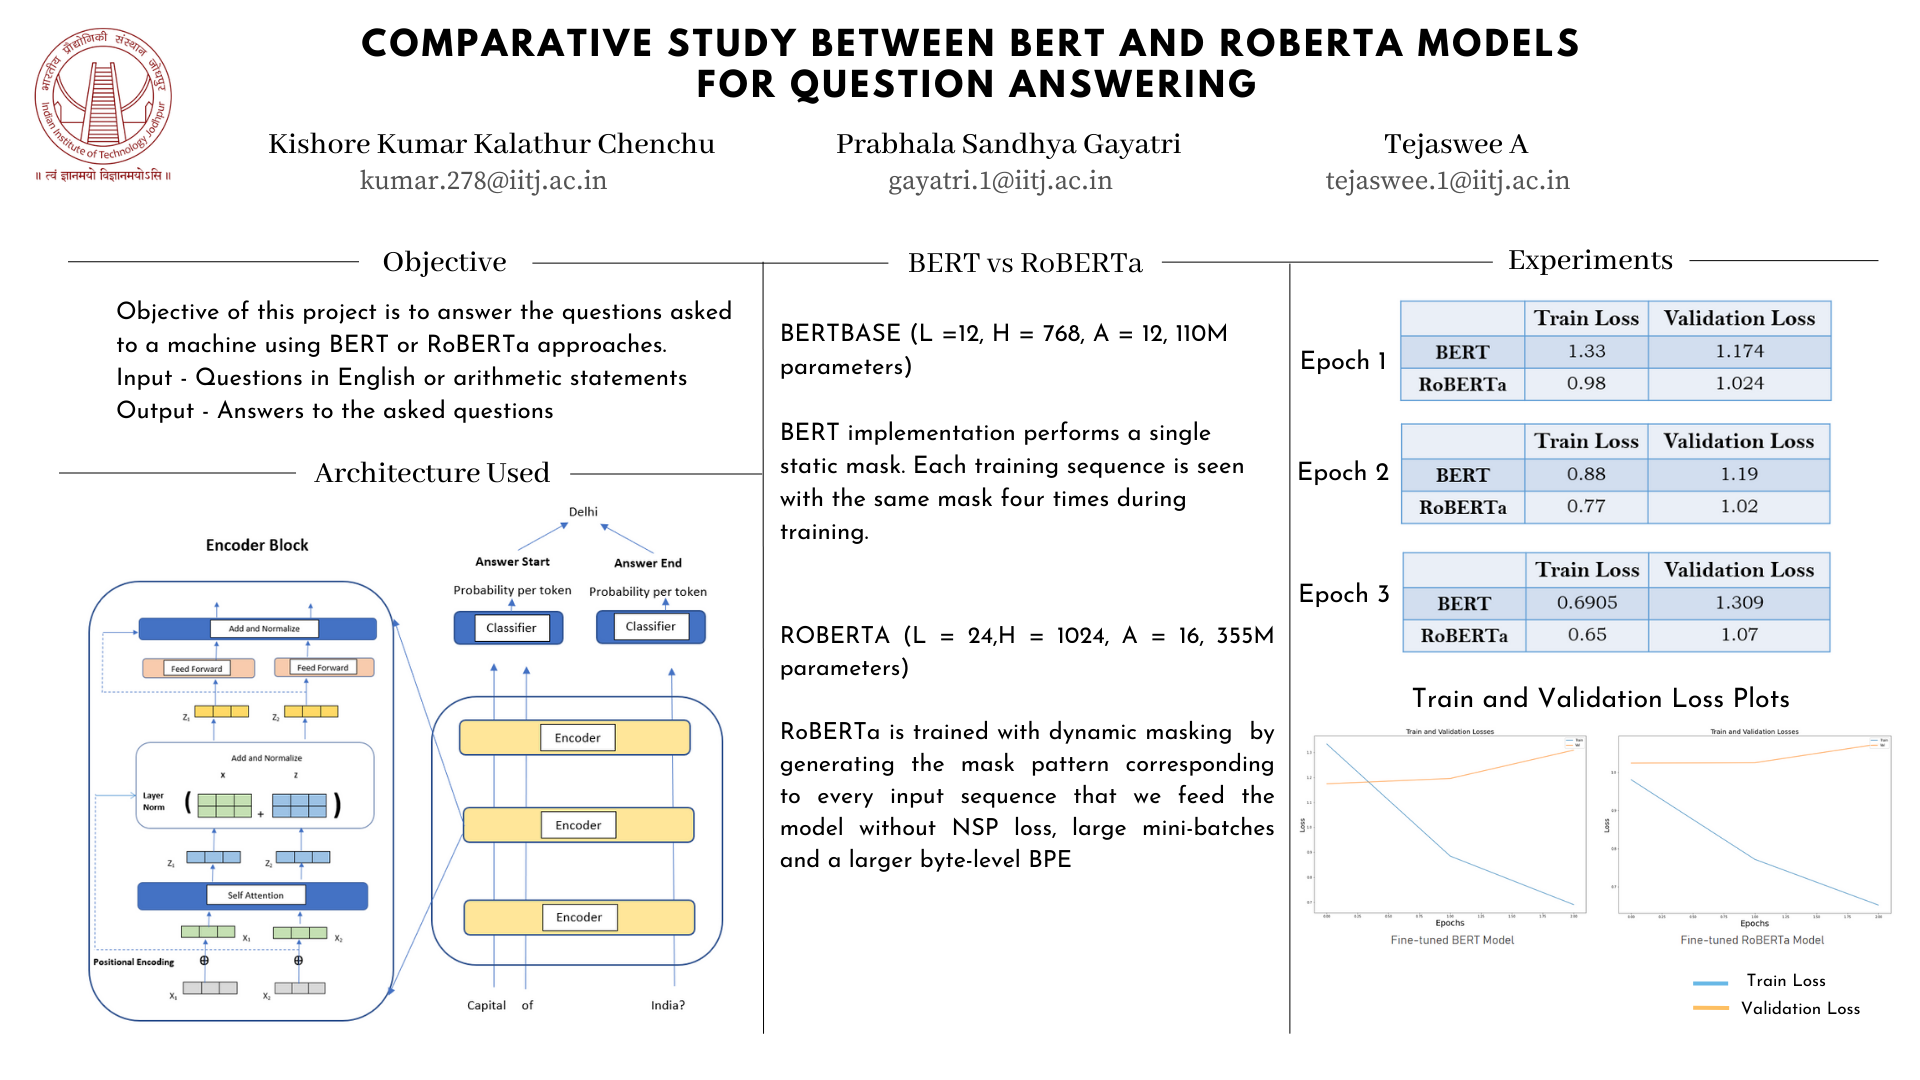